<a href="https://colab.research.google.com/github/UMA314159/-morning4-Image-Classification/blob/main/Xception%E3%83%95%E3%82%A1%E3%82%A4%E3%83%B3%E3%83%81%E3%83%A5%E3%83%BC%E3%83%8B%E3%83%B3%E3%82%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#google ColabのDriveモジュールをインポートして、Googleドライブをマウントする許可を実行する。
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#データ処理ライブラリ
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , accuracy_score

# 画像処理ライブラリ
import cv2
from PIL import Image

#可視化ライブラリ
import matplotlib.pyplot as plt

#keras
import keras as ks
from keras.models import Sequential
from keras.layers import Dense , Dropout , Flatten , Conv2D , MaxPooling2D , BatchNormalization , Activation
from keras.utils import np_utils
from keras.initializers import he_normal
from keras.preprocessing.image import ImageDataGenerator , load_img , img_to_array , array_to_img
from keras import regularizers
from keras import optimizers

#学習済みモデルVGG16
from keras.applications.xception import Xception

#Pythonモジュール
import os
import glob

#表示設定
pd.options.display.max_rows = 78
pd.options.display.max_columns = 78

In [ ]:
# データの読み込み
train_Y = pd.read_csv('/content/drive/MyDrive/data/train_master.tsv', delimiter='\t')
# ラベル名の削除
train_Y = train_Y.drop('file_name', axis=1)
# カテゴリー変数へ変換
Y = np_utils.to_categorical(train_Y,10)
print(Y.shape)

(5000, 10)


In [ ]:
#train_imagesディレクトリ内のデータをリストに格納
train_file = glob.glob('/content/drive/MyDrive/data/train_images/train_images/t*')
len(train_file)

5000

In [ ]:
# 番号順に並び替える関数
import re
from collections import OrderedDict

def sortedStringList(array=[]):
    sortDict=OrderedDict()
    for splitList in array:
        sortDict.update({splitList:[int(x) for x in re.split("(\d+)",splitList)if bool(re.match("\d*",x).group())]})
    return [sortObjKey for sortObjKey,sortObjValue in sorted(sortDict.items(), key=lambda x:x[1])]

sort_file = sortedStringList(train_file)
sort_file[:5]

['/content/drive/MyDrive/data/train_images/train_images/train_0.jpg',
 '/content/drive/MyDrive/data/train_images/train_images/train_1.jpg',
 '/content/drive/MyDrive/data/train_images/train_images/train_2.jpg',
 '/content/drive/MyDrive/data/train_images/train_images/train_3.jpg',
 '/content/drive/MyDrive/data/train_images/train_images/train_4.jpg']

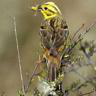

In [ ]:
image = load_img(sort_file[0])
image

In [ ]:
#画像の前処理
X = []
for img in sort_file:
    #画像ファイルの読み込み
    image = load_img(img)
    #画像ファイルのnumpy化　＋　正規化
    image = img_to_array(image) / 255.0
    #リストへ格納
    X.append(image)
    if len(X) % 1000 == 0:
        print(len(X))


#リストデータをnumpy化
X_np = np.array(X)
print(X_np.shape)
print(X_np.dtype)

1000
2000
3000
4000
5000
(5000, 96, 96, 3)
float32


In [ ]:
#データの分割
X_train , X_valid , Y_train , Y_valid = train_test_split(X_np , Y , test_size=0.3 , random_state=1)

#形状を確認
print('Y_train=' , Y_train.shape , 'X_train=' , X_train.shape)
print('Y_valid=' , Y_valid.shape , 'X_valid=' , X_valid.shape)

Y_train= (3500, 10) X_train= (3500, 96, 96, 3)
Y_valid= (1500, 10) X_valid= (1500, 96, 96, 3)


In [ ]:
image_gen = ImageDataGenerator(
    rotation_range=45, #45°回転
    horizontal_flip=True, #水平反転
    width_shift_range=0.1,
    height_shift_range=0.1
)

#元となるデータ数を増やす
X_gen = image_gen.flow(X_train, Y_train, batch_size=32)

#画像データを格納
X = []
#ラベルデータを格納
Y = []

for _ in range(10):
    #データ生成
    X_gen_new , y_gen_new = X_gen.__next__()
    #データを結合
    X_train = np.concatenate([X_train , X_gen_new])
    Y_train = np.concatenate([Y_train , y_gen_new])
    X.append(X_train)
    Y.append(Y_train)
    #データサイズを表示
    print(X_train.shape , Y_train.shape)

(3532, 96, 96, 3) (3532, 10)
(3564, 96, 96, 3) (3564, 10)
(3596, 96, 96, 3) (3596, 10)
(3628, 96, 96, 3) (3628, 10)
(3660, 96, 96, 3) (3660, 10)
(3692, 96, 96, 3) (3692, 10)
(3724, 96, 96, 3) (3724, 10)
(3756, 96, 96, 3) (3756, 10)
(3788, 96, 96, 3) (3788, 10)
(3820, 96, 96, 3) (3820, 10)


In [ ]:
X_train = X[-1]
Y_train = Y[-1]
print(X_train.shape , Y_train.shape)

(3820, 96, 96, 3) (3820, 10)


In [ ]:
#1行5列のグリッド形式で画像をプロットする関数
def plotImages(images_arr):
     fig , axes = plt.subplots(1,5,figsize=(20,20))
     axes = axes.flatten()
     for img , ax in zip( images_arr , axes):
         ax.imshow(img)
         ax.axis('off')
     plt.tight_layout()
     plt.show()

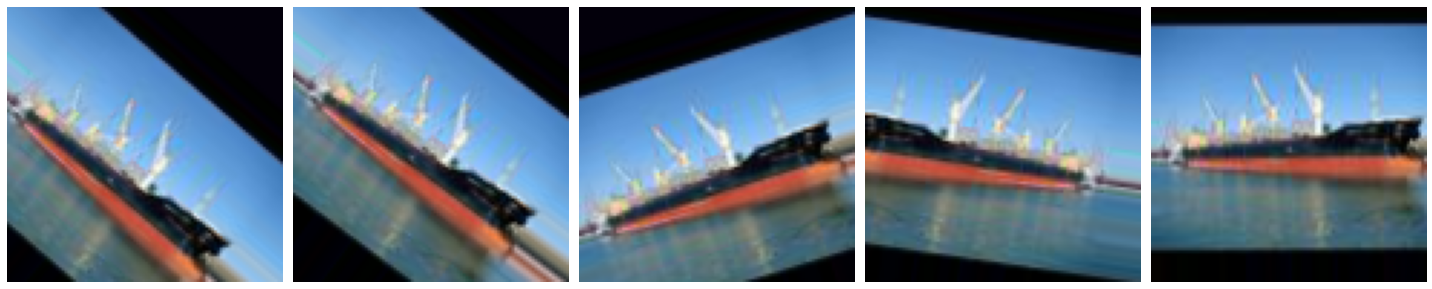

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [ ]:
#教師データをまとめる
train_data_gen = image_gen.flow(X_train , Y_train , batch_size=32, shuffle=False)
augmented_images = [train_data_gen[15][0][31] for i in range(5)]

#表示
plotImages(augmented_images)
train_data_gen[15][1][31]

In [ ]:
#検証データも教師データと同じ形へ変更
valid_gen = ImageDataGenerator()
valid_data_gen = valid_gen.flow(X_valid , Y_valid , batch_size=32)

In [ ]:
#学習済みモデルXceptionの読み込み
base_model =Xception(
    weights='imagenet', #学習済の重みを利用
    include_top= False, #出力の全結合層は使わない
    input_shape=(96,96,3) #入力の値
)
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 47, 47, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 47, 47, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                                  
 block1_conv1_act (Activation)  (None, 47, 47, 32)   0           ['block1_conv1_bn[0][0]'] 

In [ ]:
#最後のconv層の直前までの層を凍結する
for layer in base_model.layers[:-32]:
    layer.trainable = False

In [ ]:
#重みが固定（False）されているかの確認
for layer in base_model.layers:
    print(layer , layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f3a4d016390> False
<keras.layers.convolutional.Conv2D object at 0x7f3a49b08d50> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f3a482b98d0> False
<keras.layers.core.activation.Activation object at 0x7f3a4825d2d0> False
<keras.layers.convolutional.Conv2D object at 0x7f3a400ea250> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f3a40082350> False
<keras.layers.core.activation.Activation object at 0x7f3a482b9950> False
<keras.layers.convolutional.SeparableConv2D object at 0x7f3a4d545990> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f3a400aab10> False
<keras.layers.core.activation.Activation object at 0x7f3a4003df10> False
<keras.layers.convolutional.SeparableConv2D object at 0x7f3a4825d090> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f3a40041fd0> False
<keras.layers.convolutional.Co

In [ ]:
# Xceptionのモデルに全結合分類を追加する
model2 = Sequential()
model2.add(base_model)

# モデルの作成
model2.add(Flatten()) 
model2.add(Dense(256))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.5))

model2.add(Dense(256))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(10, activation='softmax'))
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 256)               4718848   
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

In [ ]:
#モデルコンパイル　確率的勾配効果法
model2.compile(loss='categorical_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

In [ ]:
#EarlyStoppingの設定
from keras.callbacks import EarlyStopping
callbacks = EarlyStopping(monitor='val_loss' , patience=15)

In [ ]:
#モデルの訓練
log = model2.fit_generator(train_data_gen,
                 steps_per_epoch=len(X_train) / 64,
                 epochs=150,
                 callbacks = [callbacks],
                 validation_data=(X_valid , Y_valid))

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


59/59 [==============================] - 15s 136ms/step - loss: 2.2549 - accuracy: 0.2437 - val_loss: 2.7930 - val_accuracy: 0.3833
Epoch 2/150
59/59 [==============================] - 7s 115ms/step - loss: 1.4080 - accuracy: 0.5115 - val_loss: 1.0583 - val_accuracy: 0.6713
Epoch 3/150
59/59 [==============================] - 7s 115ms/step - loss: 1.0685 - accuracy: 0.6661 - val_loss: 1.2149 - val_accuracy: 0.7180
Epoch 4/150
59/59 [==============================] - 7s 109ms/step - loss: 0.8978 - accuracy: 0.7172 - val_loss: 0.8636 - val_accuracy: 0.7813
Epoch 5/150
59/59 [==============================] - 7s 110ms/step - loss: 0.8427 - accuracy: 0.7359 - val_loss: 0.8377 - val_accuracy: 0.7520
Epoch 6/150
59/59 [==============================] - 7s 113ms/step - loss: 0.7519 - accuracy: 0.7721 - val_loss: 0.9235 - val_accuracy: 0.7747
Epoch 7/150
59/59 [==============================] - 7s 111ms/step - loss: 0.7052 - accuracy: 0.7802 - val_loss: 0.8055 - val_accuracy: 0.7780
Epoch 8/15

In [ ]:
image_test_features = np.load('/content/drive/MyDrive/data/test_X_features.npy')

In [ ]:
image_test_features = image_test_features.astype('float32')
image_test_features /= 255
image_test_features = image_test_features.reshape(image_test_features.shape[0] , 96 , 96 , 3)

In [ ]:
pred_y = model2.predict(image_test_features)
#pred_y = np.argmax(pred_y , axis=1)

In [ ]:
#sampl_submitデータ
sample = pd.read_table('/content/drive/MyDrive/data/sample_submit.tsv' , index_col = 0 , header=None)
sample[1] = pred_y
sample

,1
0,
test_0.jpg,5.439152e-07
test_1.jpg,6.352612e-05
test_2.jpg,1.049870e-02
test_3.jpg,9.995531e-01
test_4.jpg,4.924669e-05
...,...
test_7995.jpg,1.108073e-05
test_7996.jpg,3.398447e-06
test_7997.jpg,3.855749e-03


In [ ]:
sample.to_csv('/content/drive/MyDrive/Colab Notebooks/-morning4-SIGNATE-画像ラベリング/submit/ensemble1.tsv' ,sep='\t' , header=None)